In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import cv2
import os
import seaborn as sns

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
!rm -rf archive_full_z

In [ ]:
!wget http://pdd.jinr.ru/archive_full_z.zip

--2021-10-04 01:00:20--  http://pdd.jinr.ru/archive_full_z.zip
Resolving pdd.jinr.ru (pdd.jinr.ru)... 159.93.223.250
Connecting to pdd.jinr.ru (pdd.jinr.ru)|159.93.223.250|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105849833 (101M) [application/zip]
Saving to: ‘archive_full_z.zip’

100%[======================================>] 105,849,833  406MB/s   in 0.2s   

2021-10-04 01:00:20 (406 MB/s) - ‘archive_full_z.zip’ saved [105849833/105849833]



In [ ]:
#!rm -rf archive_full

In [ ]:
# инициализировать количество эпох для тренировки, начальную скорость обучения,
# размер пакета и размеры изображения
EPOCHS = 100
INIT_LR = 1e-4 #начальнаня скорость обучения
BS = 16 #контролирует размер пакетов передаваемых на обучение
IMAGE_DIMS = (224, 224, 3) # размеры изображения и 3х канальный RGB

# инициализируем данные и метки
data = []
labels = []

# захватываем пути изображения и случайным образом перемешиваем их
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images("archive_full_z")))
random.seed(42)
random.shuffle(imagePaths)

[INFO] loading images...


In [ ]:
for imagePath in imagePaths:
    
    # загружаем изображение, предварительно обработать его и сохранив в списке данных
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image) #  преобразования изображения в массив, совместимый с Keras
    data.append(image)
    
    # извлекаем метку класса из пути к изображению и обновляем
    # список ярлыков
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [ ]:
# Считывание меток
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels)

# масштабировать яркость необработанных пикселей в диапазоне [0, 1]
data = np.array(data, dtype="float") 
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 1868.66MB


In [ ]:
trainX.shape

(2542, 224, 224, 3)

In [ ]:
testX.shape

(636, 224, 224, 3)

In [ ]:
testY.shape

(636, 74)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state = 42)

In [ ]:
TestX = testX
TestY = testY
TestX = np.array(TestX, dtype="float") 

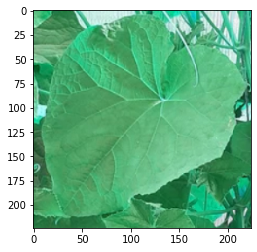

In [ ]:
plt.imshow(TestX[0]/255)

In [ ]:
trainX = preprocess_input(trainX)
testX = preprocess_input(testX)

In [ ]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [ ]:
base_model = MobileNetV2(include_top = False, weights = 'imagenet', input_shape = IMAGE_DIMS)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
model_layers = base_model.output
model_layers = AveragePooling2D(pool_size=(7, 7))(model_layers)
model_layers = Flatten(name="flatten")(model_layers)
model_layers = Dense(1024, activation="relu")(model_layers)
model_layers = Dropout(0.5)(model_layers)
model_layers = Dense(45, activation="softmax")(model_layers)

model = Model(inputs=base_model.input, outputs=model_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')

In [ ]:
history = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    callbacks=[learning_rate_reduction])

Epoch 1/100
79/79 [==============================] - 18s 231ms/step - loss: 3.7475 - acc: 0.0980 - val_loss: 3.4232 - val_acc: 0.1604
Epoch 2/100
79/79 [==============================] - 18s 233ms/step - loss: 3.1838 - acc: 0.2072 - val_loss: 2.9738 - val_acc: 0.2830
Epoch 3/100
79/79 [==============================] - 18s 229ms/step - loss: 2.7377 - acc: 0.3004 - val_loss: 2.6841 - val_acc: 0.2862
Epoch 4/100
79/79 [==============================] - 18s 223ms/step - loss: 2.4132 - acc: 0.3649 - val_loss: 2.4498 - val_acc: 0.3176
Epoch 5/100
79/79 [==============================] - 18s 230ms/step - loss: 2.1322 - acc: 0.4271 - val_loss: 2.3761 - val_acc: 0.3145
Epoch 6/100
79/79 [==============================] - 18s 229ms/step - loss: 1.8996 - acc: 0.4908 - val_loss: 2.1993 - val_acc: 0.3616
Epoch 7/100
79/79 [==============================] - 17s 221ms/step - loss: 1.7512 - acc: 0.5155 - val_loss: 2.1018 - val_acc: 0.3836
Epoch 8/100
79/79 [==============================] - 17s 217ms

KeyError: 'accuracy'

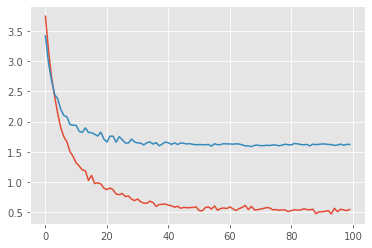

In [ ]:
# График точности и потерь при обучении
plt.style.use("ggplot")
plt.figure()
N = 100
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

### Средняя точность

In [ ]:
model.save('Transfer_MobilNet_V_2.h5')

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model_res = load_model('Transfer_MobilNet_V_2.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
prediction = model_res.predict(testX)

In [ ]:
print("prediction",prediction)
print("PROBA",np.argmax(prediction, axis=1))

prediction [[6.31979944e-08 2.63248921e-07 1.25622520e-07 ... 5.32050599e-08
  1.92135534e-08 3.22703301e-07]
 [1.35922892e-04 2.78860934e-05 3.52248426e-05 ... 2.94679310e-04
  2.23347179e-05 9.41181315e-06]
 [1.77949667e-04 3.67870816e-05 2.07242454e-04 ... 4.74599452e-04
  1.93176733e-04 3.30607174e-04]
 ...
 [1.56656881e-06 2.01754490e-04 5.95872052e-06 ... 1.23626742e-05
  1.76654226e-04 3.65859114e-06]
 [3.11429394e-05 6.81324400e-06 1.77192010e-06 ... 1.09345765e-05
  6.81506390e-06 6.05707173e-05]
 [1.27019826e-04 2.39892033e-04 2.24965697e-06 ... 2.35676612e-06
  1.40076838e-06 7.88479520e-05]]
PROBA [17 29 32 10  8 20  0 18  6 18 36 22 13 32 30 26 24 18 15 11 15  3  3  7
  9 16 29 18 24  2 22 24 23  8  6  7 23 29 14 18 18 18 18 31 23 28 14  4
  6  7 15 27 16 34 21 27 24 22 12  9 36 28 25 29  5 16 12 18 33 22  9 22
 29 28 21 16 16 32  2  5 36 16  6 24 28 32  3 17 18 14 29 30 26 18 18  1
 18  7 30 16 12 16 31 23 35 22 13 10 34 22 22 18 21 14 23  1 18 34  7  9
 32  5 31  9 18 37

In [ ]:
print(testY)
prediction[2]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


array([1.7794967e-04, 3.6787082e-05, 2.0724245e-04, 4.7010265e-04,
       1.7714118e-04, 8.8553870e-04, 9.4912459e-05, 5.4568551e-05,
       2.1661812e-04, 3.3334331e-04, 9.3303854e-04, 5.0438143e-04,
       2.0130984e-04, 6.5911998e-05, 9.3962898e-04, 3.4236934e-04,
       1.3382281e-05, 2.1455108e-04, 1.8841381e-05, 3.0232724e-04,
       2.3736323e-03, 1.1117025e-03, 1.3998194e-04, 1.9267536e-04,
       9.4727632e-03, 4.0493188e-03, 5.3306613e-03, 1.9519940e-02,
       1.7444542e-04, 1.5720631e-01, 7.9467170e-02, 3.3348754e-02,
       6.7935699e-01, 7.7469955e-04, 2.9257021e-04, 4.7459945e-04,
       1.9317673e-04, 3.3060717e-04], dtype=float32)

In [ ]:
test_loss, test_acc = model_res.evaluate(testX, testY)
print("Test loss: {}, Test Accuracy {}".format(test_loss, test_acc))

9/9 [==============================] - 0s 15ms/step - loss: 0.9038 - accuracy: 0.7326
Test loss: 0.9038273096084595, Test Accuracy 0.732600748538971


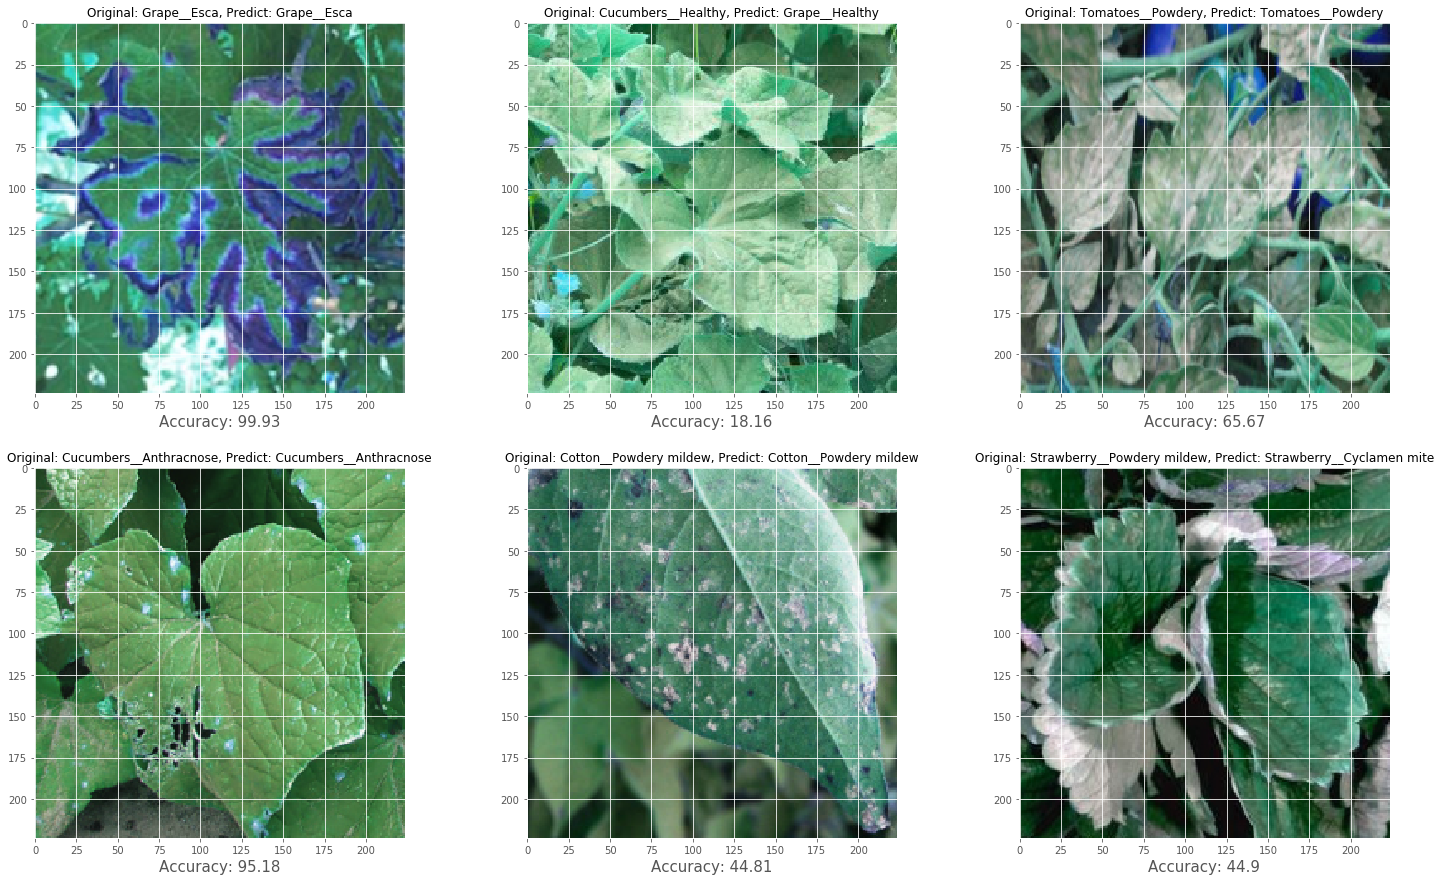

In [ ]:
plt.figure(figsize=(25,15))
columns = 5
for i in range(0, 6):
    #testX = np.array(testX, dtype="float")
    accuracy = round(prediction[i][np.argmax(prediction[i])]*100, 2)
    plt.subplot(2, 3, i + 1)
    plt.imshow(TestX[i]/255)
    plt.title("Original: {}, Predict: {}".format(lb.inverse_transform(testY)[i], lb.inverse_transform(prediction)[i],), size=12)
    plt.xlabel("Accuracy: {}".format(accuracy), size=15)

In [ ]:
pred = lb.inverse_transform(prediction)
pred = pd.DataFrame({'predict': pred})

In [ ]:
truth = lb.inverse_transform(testY)
truth = pd.DataFrame({'truth': truth})

In [ ]:
final = truth.join(pred)

In [ ]:
final.to_csv('Prediction_Transfer_MobilNet_V_2.csv', index=False)

In [ ]:
final = pd.read_csv("Prediction_Transfer_MobilNet_V_2.csv")
classes = final.truth.unique()
classes.sort()

In [ ]:
conf_matrix = confusion_matrix(lb.inverse_transform(testY), lb.inverse_transform(prediction))

In [ ]:
df = pd.DataFrame(conf_matrix.transpose(), index=classes, columns=classes,)

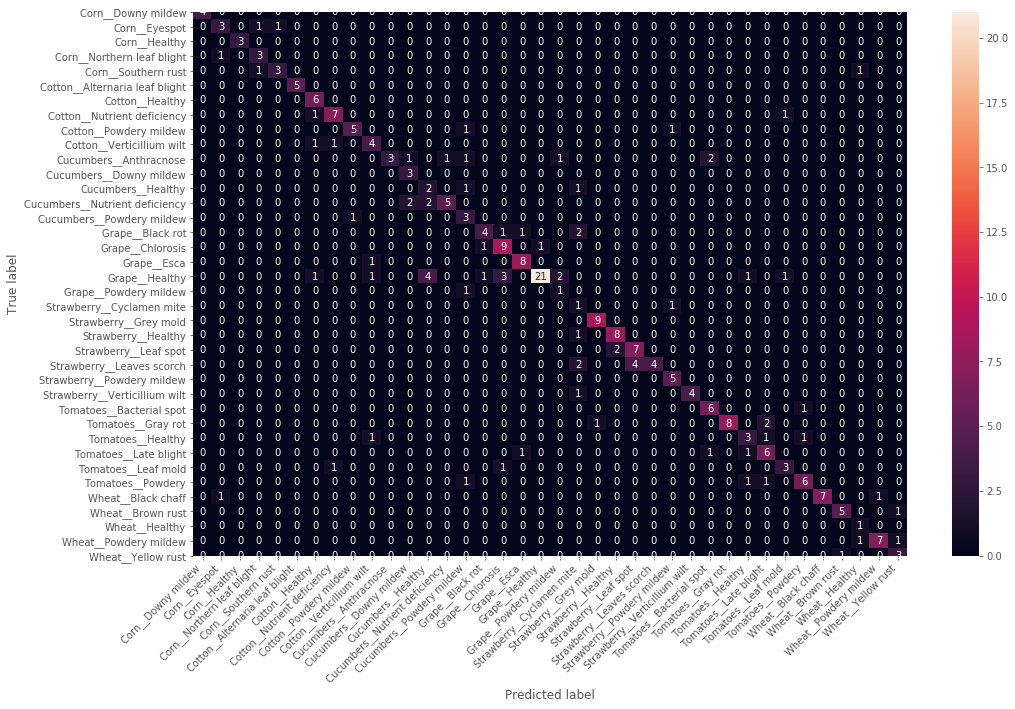

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))
ax = sns.heatmap(df, annot = True, fmt = 'd', ax = ax)
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Other dataset

In [ ]:
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images("test_base")))

[INFO] loading images...


In [ ]:
test_base = []
labels_test = []
#Перебираем изображения 
for imagePath in imagePaths:
    
    # загружаем изображение, предварительно обработать его и сохранив в списке данных
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image) #  преобразования изображения в массив, совместимый с Keras
    test_base.append(image)
    
    label = imagePath.split(os.path.sep)[-2]
    labels_test.append(label)

In [ ]:
labels_test = np.array(labels_test)

# Считывание меток
lb = LabelBinarizer()
labels_test = lb.fit_transform(labels_test)

In [ ]:
test_base = np.array(test_base, dtype="float")
test_b = test_base

In [ ]:
test_b = test_base 
test_b = preprocess_input(test_b)

In [ ]:
prediction_test = model_res.predict([test_b])

In [ ]:
test_loss, test_acc = model_res.evaluate(test_base, labels_test)
print("Test loss: {}, Test Accuracy {}".format(test_loss, test_acc))

4/4 [==============================] - 2s 366ms/step - loss: 0.3469 - accuracy: 0.9200
Test loss: 0.3469387888908386, Test Accuracy 0.9200000166893005


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


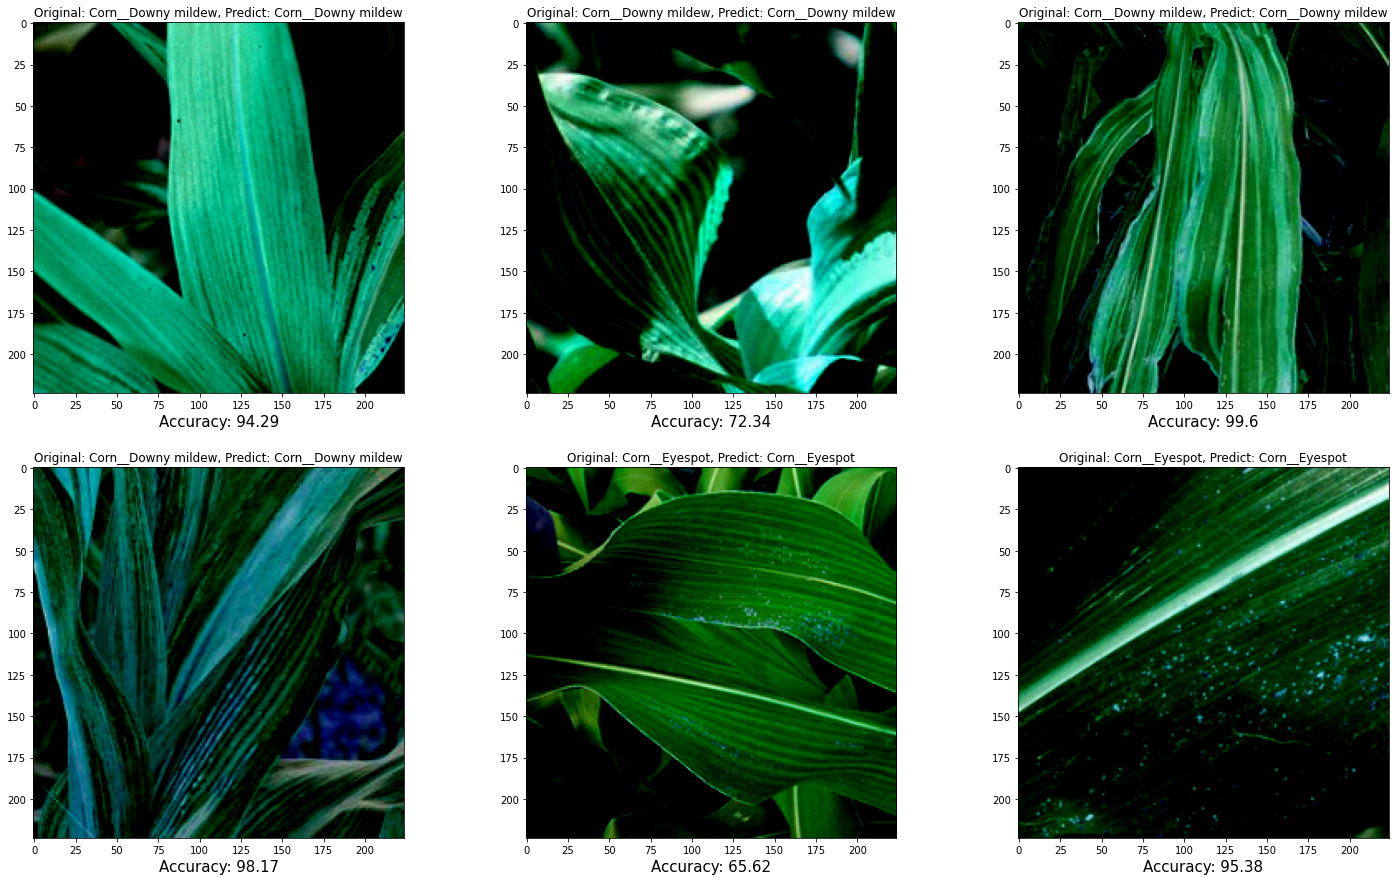

In [ ]:
plt.figure(figsize=(25,15))
columns = 5
for i in range(0, 6):
    accuracy = round(prediction_test[i][np.argmax(prediction_test[i])]*100, 2)
    plt.subplot(2, 3, i + 1)
    plt.imshow(test_b[i])
    plt.title("Original: {}, Predict: {}".format(lb.inverse_transform(labels_test)[i], lb.inverse_transform(prediction_test)[i],), size=12)
    plt.xlabel("Accuracy: {}".format(accuracy), size=15)

In [ ]:
pred = lb.inverse_transform(prediction)
pred = pd.DataFrame({'predict': pred})

In [ ]:
truth = lb.inverse_transform(testY)
truth = pd.DataFrame({'truth': truth})

In [ ]:
final = truth.join(pred)

In [ ]:
final.to_csv('Prediction_trans.csv', index=False)

In [ ]:
final = pd.read_csv("Prediction_trans.csv")
classes = final.truth.unique()
classes.sort()

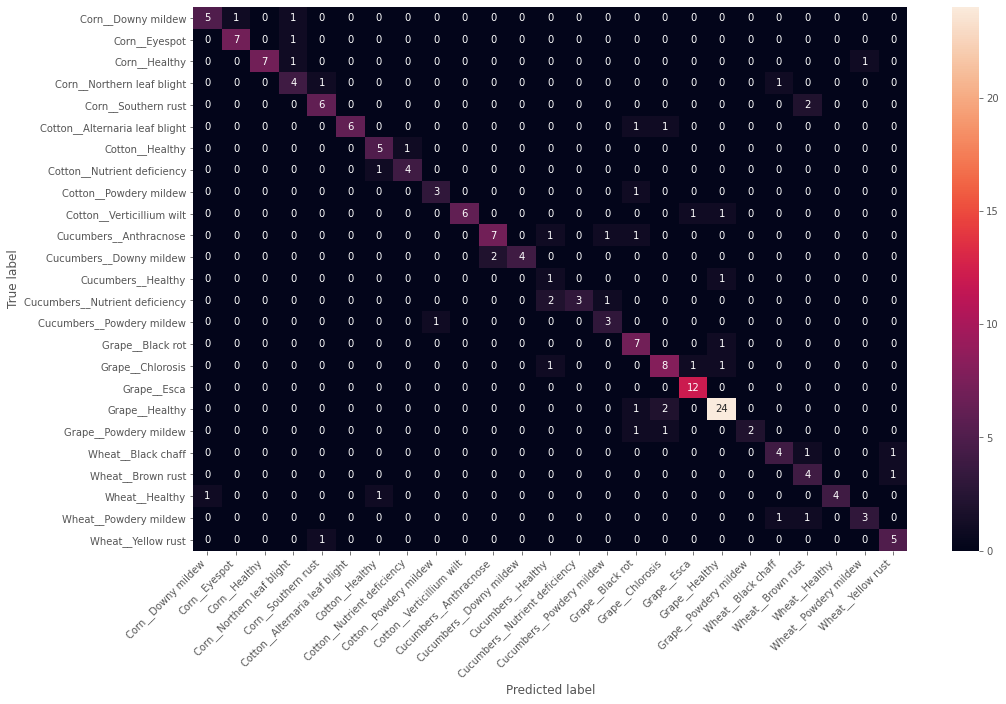

In [ ]:
conf_matrix = confusion_matrix(lb.inverse_transform(testY), lb.inverse_transform(prediction))

df = pd.DataFrame(conf_matrix, index=classes, columns=classes, )

fig, ax = plt.subplots(figsize=(16, 10))
ax = sns.heatmap(df, annot = True, fmt = 'd', ax = ax)
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
pred = lb.inverse_transform(prediction_test)
pred = pd.DataFrame({'predict': pred})

In [ ]:
truth = lb.inverse_transform(labels_test)
truth = pd.DataFrame({'truth': truth})

In [ ]:
final = truth.join(pred)

In [ ]:
final.to_csv('Prediction_test_trans.csv', index=False)

In [ ]:
final = pd.read_csv("Prediction_test_trans.csv")
classes = final.truth.unique()
classes.sort() 

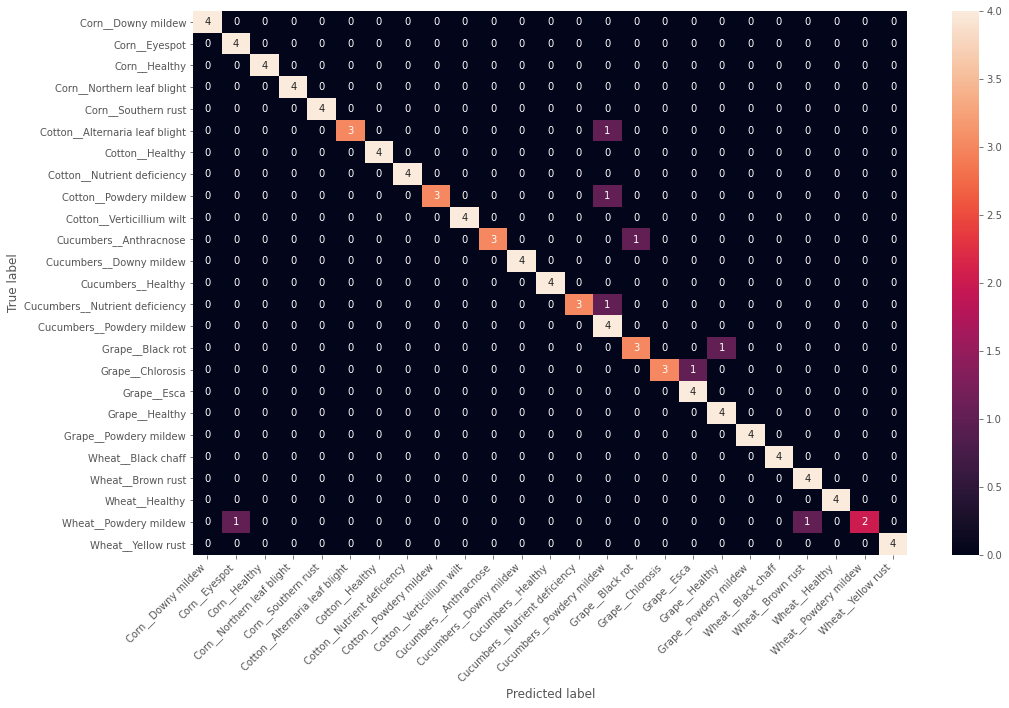

In [ ]:
conf_matrix = confusion_matrix(lb.inverse_transform(labels_test), lb.inverse_transform(prediction_test))

df = pd.DataFrame(conf_matrix, index=classes, columns=classes, )

fig, ax = plt.subplots(figsize=(16, 10))
ax = sns.heatmap(df, annot = True, fmt = 'd', ax = ax)
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
x = x.cuda()

NameError: name 'x' is not defined

In [ ]:
import torch
device = torch.device("cuda:0")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
!nvidia-smi

Thu Sep 22 13:49:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   37C    P0    54W / 300W |  19392MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   